# Final Capstone Project

### Week 2

### PART 1 IMPORTING AND CLEANING DATA

In [3]:
#import library to extract from database
import ibm_db

In [4]:
#@hidden cell 
#Enter your database credentials
dsn_hostname = "dashdb-txn-sbox-yp-lon02-02.services.eu-gb.bluemix.net"
dsn_uid = "sgv09508"
dsn_pwd = "9xx^15fsqltkn80r" 
dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "BLUDB"           
dsn_port = "50000"             
dsn_protocol = "TCPIP"

In [297]:
#@hidden cell 
#Create the dsn connection string
dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd)

#print the connection string to check correct values are specified
print(dsn)

#Create database connection
try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)
except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

DRIVER={IBM DB2 ODBC DRIVER};DATABASE=BLUDB;HOSTNAME=dashdb-txn-sbox-yp-lon02-02.services.eu-gb.bluemix.net;PORT=50000;PROTOCOL=TCPIP;UID=sgv09508;PWD=9xx^15fsqltkn80r;
Connected to database:  BLUDB as user:  sgv09508 on host:  dashdb-txn-sbox-yp-lon02-02.services.eu-gb.bluemix.net


In [298]:
#import libraries 
import pandas
import ibm_db_dbi
pconn = ibm_db_dbi.Connection(conn)

In [15]:
#import data from CHICAGO_PUBLIC_SCHOOLS
selectQuery = "select * from CHICAGO_PUBLIC_SCHOOLS"
Chicago_publicschool = pandas.read_sql(selectQuery, pconn)
Chicago_publicschool = Chicago_publicschool[["NAME_OF_SCHOOL","ZIP_Code","SAFETY_SCORE","COMMUNITY_AREA_NAME","Latitude","Longitude"]]
Chicago_publicschool[["NAME_OF_SCHOOL","ZIP_Code","SAFETY_SCORE","COMMUNITY_AREA_NAME","Latitude","Longitude"]].head()

,NAME_OF_SCHOOL,ZIP_Code,SAFETY_SCORE,COMMUNITY_AREA_NAME,Latitude,Longitude
0,Abraham Lincoln Elementary School,60614,99.0,LINCOLN PARK,41.924497,-87.644522
1,Adam Clayton Powell Paideia Community Academy ...,60649,54.0,SOUTH SHORE,41.760324,-87.556736
2,Adlai E Stevenson Elementary School,60652,61.0,ASHBURN,41.747111,-87.731702
3,Agustin Lara Elementary Academy,60609,56.0,NEW CITY,41.809757,-87.672145
4,Air Force Academy High School,60609,49.0,ARMOUR SQUARE,41.828146,-87.632794


In [14]:
#statistical testing of dataset to understand data
Chicago_publicschool['SAFETY_SCORE'].describe()

count    513.000000
mean      49.504873
std       20.110837
min        1.000000
25%       35.000000
50%       48.000000
75%       61.000000
max       99.000000
Name: SAFETY_SCORE, dtype: float64

We can see above that the minimum safety score is 1 and the max is 99. We can also see other statistics, like the mean score being 49.5 and that 75% of all safety scores are below 61. <br><br>We would like to sort the safety score in descending order in order to see the top 5 safest communities (and thus, zipcode). 

In [16]:
#Sort by safety score descending to determine safest 
Chicago_publicschool[["COMMUNITY_AREA_NAME","SAFETY_SCORE","ZIP_Code","Latitude","Longitude"]]
Chicago_publicschool_group=Chicago_publicschool.groupby("COMMUNITY_AREA_NAME",axis=0).mean()
Chicago_publicschool_group.reset_index(inplace = True)
Chicago_publicschool_group.sort_values(["SAFETY_SCORE"], axis=0, ascending=False, inplace=False).head()

,COMMUNITY_AREA_NAME,ZIP_Code,SAFETY_SCORE,Latitude,Longitude
24,FOREST GLEN,60646.000000,99.000000,41.999368,-87.762061
41,LOOP,60605.000000,92.000000,41.874419,-87.627755
46,MOUNT GREENWOOD,60655.000000,86.500000,41.692870,-87.706007
51,NORTH CENTER,60623.571429,85.166667,41.944746,-87.684155
38,LINCOLN PARK,60614.000000,81.833333,41.921793,-87.649618


In [17]:
#set the index of the dataset to commmunity_area_name so that we can focus on solely those 5 communities 
Chicago_publicschool.set_index('COMMUNITY_AREA_NAME', inplace=True)

In [18]:
#create dataframe with top 5 safest communities
Chicago=Chicago_publicschool.loc[["FOREST GLEN","LOOP","MOUNT GREENWOOD","NORTH CENTER","LINCOLN PARK"],["ZIP_Code","Latitude","Longitude"]]
Chicago_data=Chicago.groupby('COMMUNITY_AREA_NAME', axis=0).mean()
Chicago_data

,ZIP_Code,Latitude,Longitude
COMMUNITY_AREA_NAME,,,
FOREST GLEN,60646.000000,41.999368,-87.762061
LINCOLN PARK,60614.000000,41.921793,-87.649618
LOOP,60605.000000,41.874419,-87.627755
MOUNT GREENWOOD,60655.000000,41.692870,-87.706007
NORTH CENTER,60623.571429,41.944746,-87.684155


In [19]:
#change datatype 
Chicago_data = Chicago_data.astype({"ZIP_Code": int})
Chicago_data

,ZIP_Code,Latitude,Longitude
COMMUNITY_AREA_NAME,,,
FOREST GLEN,60646,41.999368,-87.762061
LINCOLN PARK,60614,41.921793,-87.649618
LOOP,60605,41.874419,-87.627755
MOUNT GREENWOOD,60655,41.692870,-87.706007
NORTH CENTER,60623,41.944746,-87.684155


### PART 2: PLOTTING GEOGRAPHICAL DATA TO DETERMINE GEOGRAPHICAL OUTLIERS

In [20]:
#import libraries
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import numpy as np 

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 
import requests # library to handle requests
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

#map rendering library
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

   

In [295]:
#get coordinates of Chicago 

address = 'Chicago, USA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


In [296]:
# create map  using latitude and longitude values
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng in zip(Chicago_data['Latitude'], Chicago_data['Longitude']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

You immediately notice that the community with zipcode 60655 is an outlier from the others, who are all situated north of Chicago. <BR>Therefore, we will remove this zipcode from the possibilties. The remaining possibilities are: 60646, 60614, 60605, 60623

### PART 3: IS THERE ENOUGH SUPPLY OF ICE CREAM SHOPS IN EACH ZIPCODE?

In [49]:
# The code was removed by Watson Studio for sharing.

In [50]:
#Add value to community's zipcode, lattitude and longitude values. This is the code for one zipcode.
print("Zipcode: ", Chicago_data.iloc[0,0])

neighborhood_latitude = Chicago_data.iloc[0,1] 
neighborhood_longitude = Chicago_data.iloc[0,2]
neighborhood_zipcode = Chicago_data.iloc[0,0] 

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_zipcode, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Zipcode:  60646
Latitude and longitude values of 60646 are 41.99936785, -87.76206112.


In [293]:
#get neighborhood data
LIMIT = 10 
radius = 500 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

#send request and examine results
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d1b106ef129b5002599988b'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4c0304c139d476b0bb932fa7-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/icecream_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d1c9941735',
         'name': 'Ice Cream Shop',
         'pluralName': 'Ice Cream Shops',
         'primary': True,
         'shortName': 'Ice Cream'}],
       'id': '4c0304c139d476b0bb932fa7',
       'location': {'address': '5337 W Devon Ave',
        'cc': 'US',
        'city': 'Chicago',
        'country': 'United States',
        'distance': 244,
        'formattedAddress': ['5337 W Devon Ave',
         'Chicago, IL 60646',
         'United States'],
        'labeledLatLngs': [{'label': 'display',
          'l

In [52]:
#function that extracts the category of each venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [53]:
#the following lines of code will clean the data
#clean json and return as dataframe
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns and show
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Chocolate Shoppe Ice Cream,Ice Cream Shop,41.997200,-87.762554
1,King Pho Restaurant,Vietnamese Restaurant,41.997480,-87.764492
2,Mia Figlia,Italian Restaurant,41.997474,-87.760951
3,Caldwell Woods Bicycle Trail (North Branch Trail),Trail,41.997523,-87.767365
4,Edgebrook Coffee Shop,Diner,41.996972,-87.764116


In [54]:
#function to find common venues for all neighborhoods 
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zipcode', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [55]:
#creating a dataframe 
chicago_venues = getNearbyVenues(names=Chicago_data['ZIP_Code'],
                                   latitudes=Chicago_data['Latitude'],
                                   longitudes=Chicago_data['Longitude']
                                  )

60646
60614
60605
60655
60623


In [56]:
#Number of elements in dataframe, as well as the most common venues per zipcode. 
#However, this is not very clear to determine the most common venues. We will convert this into another dataframe. 
print(chicago_venues.shape)
chicago_venues.head(10)

(50, 7)


,Zipcode,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,60646,41.999368,-87.762061,Chocolate Shoppe Ice Cream,41.997200,-87.762554,Ice Cream Shop
1,60646,41.999368,-87.762061,King Pho Restaurant,41.997480,-87.764492,Vietnamese Restaurant
2,60646,41.999368,-87.762061,Mia Figlia,41.997474,-87.760951,Italian Restaurant
3,60646,41.999368,-87.762061,Caldwell Woods Bicycle Trail (North Branch Trail),41.997523,-87.767365,Trail
4,60646,41.999368,-87.762061,Edgebrook Coffee Shop,41.996972,-87.764116,Diner
5,60646,41.999368,-87.762061,Starbucks,41.997593,-87.763911,Coffee Shop
6,60646,41.999368,-87.762061,Lee Nails,41.997213,-87.763982,Salon / Barbershop
7,60646,41.999368,-87.762061,Subway,41.997436,-87.764199,Sandwich Place
8,60646,41.999368,-87.762061,Subway,41.997620,-87.763531,Sandwich Place
9,60646,41.999368,-87.762061,Old Edgebrook,41.997291,-87.766289,Park


In [291]:
#analyze each with one hot encoding
# one hot encoding
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chicago_onehot['Zipcode'] = chicago_venues['Zipcode'] 

# move neighborhood column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]

#group by
chicago_grouped = chicago_onehot.groupby('Zipcode').mean().reset_index()
chicago_grouped.head()

,Zipcode,American Restaurant,Beer Garden,Bookstore,Breakfast Spot,Coffee Shop,Comic Shop,Convenience Store,Cuban Restaurant,Cupcake Shop,Diner,Dive Bar,Donut Shop,Fast Food Restaurant,French Restaurant,Gift Shop,Greek Restaurant,Gym / Fitness Center,Hostel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mediterranean Restaurant,Mexican Restaurant,Music Venue,Park,Pharmacy,Pizza Place,Pub,Salon / Barbershop,Sandwich Place,Theater,Trail,Vietnamese Restaurant,Wine Shop,Yoga Studio
0,60605,0.1,0.0,0.1,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.0
1,60614,0.0,0.0,0.1,0.2,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1
2,60623,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0
3,60646,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.2,0.0,0.1,0.1,0.0,0.0
4,60655,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.1,0.1,0.1,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [292]:
#create function to transform into dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#put this data into dataframe
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

#create columns according to number of top venues
columns = ['Zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Zipcode'] = chicago_grouped['Zipcode']

for ind in np.arange(chicago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Zipcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,60605,American Restaurant,Pub,Hostel,Indian Restaurant,Liquor Store,Music Venue,Cuban Restaurant,Coffee Shop,Theater,Bookstore
1,60614,Breakfast Spot,Yoga Studio,Pizza Place,French Restaurant,Japanese Restaurant,Cupcake Shop,Greek Restaurant,Salon / Barbershop,Bookstore,Comic Shop
2,60623,Gym / Fitness Center,Mediterranean Restaurant,Beer Garden,French Restaurant,Breakfast Spot,Wine Shop,Salon / Barbershop,Cuban Restaurant,Liquor Store,Mexican Restaurant
3,60646,Sandwich Place,Ice Cream Shop,Salon / Barbershop,Italian Restaurant,Diner,Coffee Shop,Park,Trail,Vietnamese Restaurant,Bookstore
4,60655,Mexican Restaurant,Gift Shop,Fast Food Restaurant,Donut Shop,Comic Shop,Convenience Store,Pizza Place,Pharmacy,Dive Bar,Diner


As we can see in the table above: <br>
1) 60605's 6th most common venue is an ice cream shop<br>
2) 60614's 7th most common venue is an ice cream shop <br>
3) 60623 does not have an ice cream shop. <br>
4) 60646's 2nd most common venue is an ice cream shop<br>
5) 60655 was removed earlier, as it is a geographical outlier<br><br>

Thus, there is sufficient supply in the zipcodes 60605, 60614 and 60646. <br>
However, it would be interesting to take a further look into 60623, as there is currently no common ice cream shop. 

### DEEPER ANALYSIS INTO CHOSEN ZIPCODE 60623 AND GENERAL BUSINESS ANALYSIS

#### RELATIONSHIP BETWEEN PER_CAPITA_INCOME AND ZIPCODE

In order to confirm the chosen zipcode, we will look at the PER_CAPITA_INCOME vs ZIPCODE. As there is a correlation between PER_CAPITA_INCOME vs the safety of a community, a high income should be correlated with a higher community safety. Thus, if the zipcode appears in the following graph, we are able to state that it is indeed in a safer community and is appropriate for further analysis. 

In [257]:
#determining whether zipcode is indeed safe by looking at per_capita_income vs community
#extract income data per community data from database 
selectQuery = "select * from CENSURDATANEW ORDER BY PER_CAPITA_INCOME desc LIMIT 10"
Incomedata = pandas.read_sql(selectQuery, pconn)
Incomedata=Incomedata[['COMMUNITY_AREA_NAME','PER_CAPITA_INCOME']]
Incomedata
Incomedata.set_index('COMMUNITY_AREA_NAME', inplace=True)

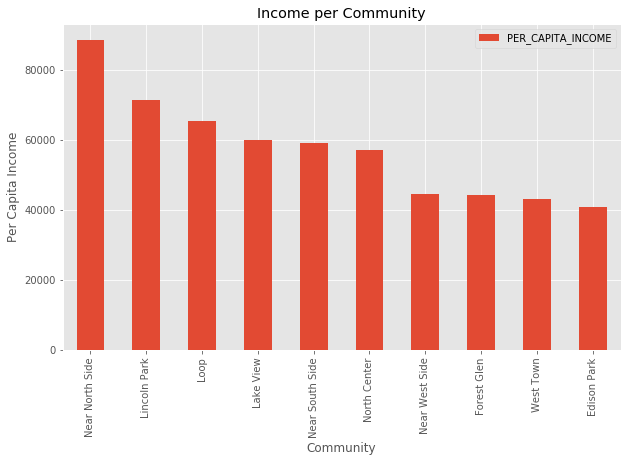

In [258]:
#import matplotlib.pyplot as plt
% matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt


#plot the relationship between the two variables 
Incomedata.plot(kind='bar', figsize=(10, 6),rot=90)
plt.xlabel('Community') # add to x-label to the plot
plt.ylabel('Per Capita Income') # add y-label to the plot
plt.title('Income per Community') # add title to the plot

plt.show()

#observation <br> Of the 4 communities, each of these communities is part of the top 6 highest income_per_capita communities. Specifically, <br> 
FOREST GLEN: 8th highest per capita income<br>
LINCOLN PARK: 2nd highest per capita income<br>
LOOP: 3rd highest per capita income<br>
NORTH CENTER: 6th highest per capita income<br><br>
Therefore, we can safely assume that the community chosen, North Center, fulfills the safety criterion and thus is an appropriate choice.

#### GROWTH OF NUMBER OF CHILDREN PER YEAR

As the target audience will be families with children, it would be interesting to look at the general trend of child growth over the years. If this is an increasing trend, this is positive and this suggests a broader customer base. The specific target audience will be children between 5-19 years old. 

In [262]:
#Extract data to determine number of children per year. 
selectQuery = "select * from TOTALPOPULATION"
totalpopulation = pandas.read_sql(selectQuery, pconn)
totalpopulation=totalpopulation[["Year","Age","Number"]]

In [263]:
#Set index to access specific elements
totalpopulation.set_index('Age', inplace=True)

In [287]:
#see sample of dataframe 
totalpopulation.head()

,Year,Number
Age,,
0-4,2017,172017
5-9,2017,150373
10-14,2017,155283
15-19,2017,153896
20-24,2017,205271


In [283]:
#create dataframes for each category of child (0-4),(5-9),(15-19),(20-24)
toddler=totalpopulation.loc['5-9']
child=totalpopulation.loc['10-14']
teenager=totalpopulation.loc['15-19']

In [284]:
#set new index for each dataframe to look at year vs number 
toddler.set_index('Year', inplace=True)
child.set_index('Year', inplace=True)
teenager.set_index('Year', inplace=True)

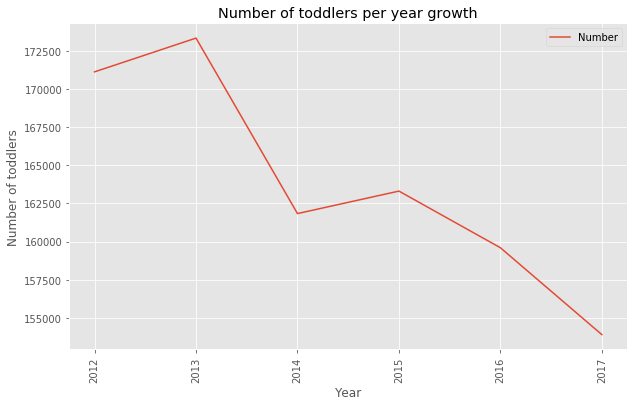

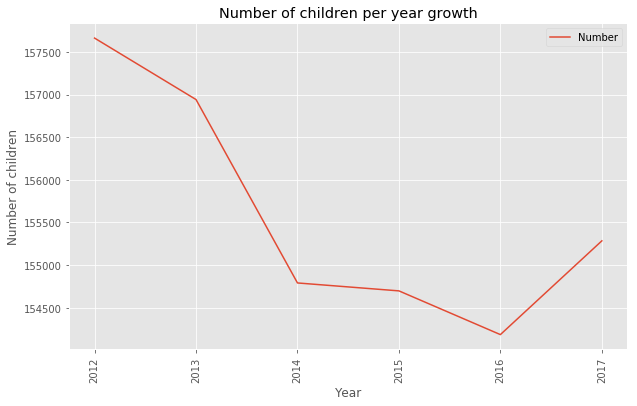

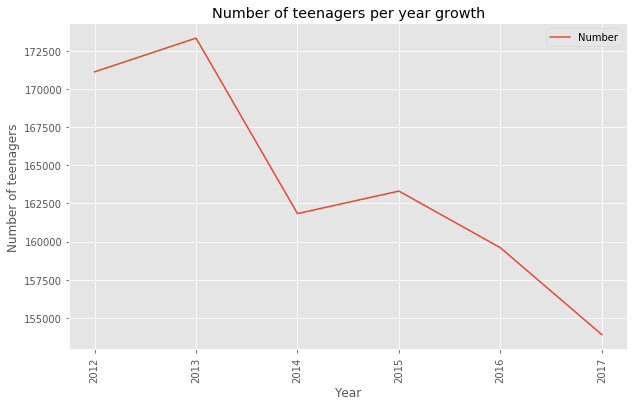

In [286]:
#import plotting libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

#choose plotting style
mpl.style.use('ggplot') 

#plot bar chart for toddlers
teenager.plot(kind='line', figsize=(10, 6),rot=90)
plt.xlabel('Year') # add to x-label to the plot
plt.ylabel('Number of toddlers') # add y-label to the plot
plt.title('Number of toddlers per year growth') # add title to the plot
plt.show()

#plot bar chart for children
child.plot(kind='line', figsize=(10, 6),rot=90)
plt.xlabel('Year') # add to x-label to the plot
plt.ylabel('Number of children') # add y-label to the plot
plt.title('Number of children per year growth') # add title to the plot
plt.show()

#plot bar chart for teenagers
teenager.plot(kind='line', figsize=(10, 6),rot=90)
plt.xlabel('Year') # add to x-label to the plot
plt.ylabel('Number of teenagers') # add y-label to the plot
plt.title('Number of teenagers per year growth') # add title to the plot
plt.show()


#observation <br> We can see in the graphs above that there is a general downward trend in number of toddlers (5-9) and teenagers (15-19) between 2012 and 2017. On the other hand, although there was an initial downward curve of number of children over the years, it is slowly increasing since 2016. Therefore, the business conclusion we can make from this data is to focus on families with children between 10-14 years old in order to maximize customer reach. 

#### RELATIONSHIP BETWEEN OBESITY AND COMMUNITY (ZIPCODE)

In [234]:
#extract governmental data to determine the health-concious behaviour of parents per community 
selectQuery = "select * from OBESITY"
Obesitydata = pandas.read_sql(selectQuery, pconn)
Obesitydata.sort_values(['WeightPercent'], ascending=True, axis=0, inplace=True)

#print number of elements in list with explanation
print(Obesitydata.shape)
print("In this dataset, there are 77 communities in which WeightPercent refers to the percentage of children whose BMI is equal to or greater than the 95th percentile on the CDC BMI-for-age growth chart, and therefore considered in the obesity class.")

#show 10 communities with lowest weight percent 
Obesitydata=Obesitydata.head(10)
Obesitydata

(77, 5)
In this dataset, there are 77 communities in which WeightPercent refers to the percentage of children whose BMI is equal to or greater than the 95th percentile on the CDC BMI-for-age growth chart, and therefore considered in the obesity class.


,Indicator,Year,Geography,Community,WeightPercent
66,Child obesity,2012-2013,Community Area,Lincoln Park,11.5
3,Child obesity,2012-2013,Community Area,Forest Glen,13.2
55,Child obesity,2012-2013,Community Area,Lakeview,13.3
33,Child obesity,2012-2013,Community Area,Lincoln Square,14.1
76,Child obesity,2012-2013,Community Area,Edison Park,14.4
1,Child obesity,2012-2013,Community Area,Norwood Park,14.4
27,Child obesity,2012-2013,Community Area,Armour Square,14.8
73,Child obesity,2012-2013,Community Area,O'Hare,15.4
25,Child obesity,2012-2013,Community Area,Loop,16.0
44,Child obesity,2012-2013,Community Area,North Center,17.4


#observation<br>
We can see in the table that all 4 communities are in the top 10 communities with lowest child weightpercent above, specifically:<br>
FOREST GLEN: 2nd lowest weightpercent<br>
LINCOLN PARK: 1st lowest weightpercent<br>
LOOP: 9th lowest weightpercent<br>
NORTH CENTER: 10th lowest weightpercent<br><br>
As we can see, North Center is part of the list. This data can both show us a threat, or opportunity with opening an icecream shop in North Center. It may be a threat, as the community is very health-concious with its resulting low child obesity score, meaning that parents do not often take their children to an "unhealthy place". On the other hand, it can be also seen as an opportunity, as we are now aware of their health-concious behaviour and thus can include "healthier" options. 

### General analysis conclusions 
Overall, the prior analyses were able to determine multiple findings: 
<br> 1. It determined the safesty communities in Chicago, using their safety score. Safety is an important criteria considering your target audience of families with children. The top 5 were chosen. <br> 2. Geographical outliers, i.e. any community which is extremely far from the rest, was not considered. This was determined using Folium. 
<br> 3. There are many competitors (i.e. sufficient supply) in the zipcodes 60605, 60614 and 60646. However, it would be interesting to take a further look into 60623 (North Center), as there is currently no common ice cream shop that families go to. 
<br> 4. A general business analysis demonstrated that there is a general downward trend in number of toddlers (5-9) and teenagers (15-19), but a slow upward trend of children (10-14). Therefore, the targe audience is refined to focus on families with children between 10-14 years old in order to maximize customer reach.
<br> 5. Deeper analysis into zipcode 60623 showed that they are one of the top 6 communities in Chicago with the highest income per capita and thus, this confirms our criterion of needing to be in a safe community. 
<br> 6. Deeper analysis into zipcode 60623 (North Center) showed that it is amongst the top 10 'healthiest' communities due to its low child obesity score. This can present both a threat and opportunity, as mentionned above. 